In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os

In [2]:
# Parameters
input_size = 64  # Adjust based on your dataset
num_classes = 36  # Assuming 26 letters + 10 digits
batch_size = 32
num_epochs = 20
learning_rate = 0.001
validation_split = 0.2  # 20% validation set

In [5]:

# Data Preparation
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization
])

dataset = datasets.ImageFolder('C:\\Users\\DELL\\Downloads\\yolodataset\\captcha_dataset_yolo', transform=transform)



In [6]:
# Split Dataset into Train and Validation
dataset_size = len(dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [7]:
# CNN Model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (input_size // 8) * (input_size // 8), 128),  # Adjust dimensions
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize Model, Loss, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [8]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        # Validation Loop
        model.eval()
        val_loss, val_correct = 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Save the model
torch.save(model.state_dict(), 'cnn_captcha_classifier.pth')


Epoch 1/20
Train Loss: 1.6509, Train Accuracy: 0.5443
Val Loss: 0.1780, Val Accuracy: 0.9450
Epoch 2/20
Train Loss: 0.2784, Train Accuracy: 0.9189
Val Loss: 0.0970, Val Accuracy: 0.9933
Epoch 3/20
Train Loss: 0.1555, Train Accuracy: 0.9534
Val Loss: 0.0763, Val Accuracy: 0.9917
Epoch 4/20
Train Loss: 0.1251, Train Accuracy: 0.9567
Val Loss: 0.0636, Val Accuracy: 0.9917
Epoch 5/20
Train Loss: 0.1276, Train Accuracy: 0.9563
Val Loss: 0.0537, Val Accuracy: 0.9917
Epoch 6/20
Train Loss: 0.0906, Train Accuracy: 0.9705
Val Loss: 0.0599, Val Accuracy: 0.9917
Epoch 7/20
Train Loss: 0.0651, Train Accuracy: 0.9784
Val Loss: 0.1028, Val Accuracy: 0.9933
Epoch 8/20
Train Loss: 0.0825, Train Accuracy: 0.9742
Val Loss: 0.0621, Val Accuracy: 0.9917
Epoch 9/20
Train Loss: 0.0527, Train Accuracy: 0.9854
Val Loss: 0.0572, Val Accuracy: 0.9933
Epoch 10/20
Train Loss: 0.0629, Train Accuracy: 0.9804
Val Loss: 0.0334, Val Accuracy: 0.9917
Epoch 11/20
Train Loss: 0.0496, Train Accuracy: 0.9867
Val Loss: 0.07

In [10]:
# Test the model with a single image
def predict_image(image_path):
    image = preprocess_image(image_path, input_size)
    image = image.to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)  # Get the class index with the highest score
    
    class_mapping = dataset.classes  # Mapping from indices to class labels
    predicted_label = class_mapping[predicted_class.item()]
    return predicted_label

# Example usage
image_path = "C:\\Users\\DELL\\Downloads\\test1.jpg"  # Path to your test image
predicted_label = predict_image(image_path)
print(f"Predicted CAPTCHA character: {predicted_label}")


Predicted CAPTCHA character: n


In [12]:
image_path = "C:\\Users\\DELL\\Downloads\\yolodataset\\captcha_dataset_yolo\\y\\yzdg2_png.rf.ada08d674a475d5822638ec9c555e1b5.jpg_char0.jpg"  # Path to your test image
predicted_label = predict_image(image_path)
print(f"Predicted CAPTCHA character: {predicted_label}")

Predicted CAPTCHA character: y


In [13]:
image_path = "C:\\Users\\DELL\\Downloads\\test2.jpg"  # Path to your test image
predicted_label = predict_image(image_path)
print(f"Predicted CAPTCHA character: {predicted_label}")

Predicted CAPTCHA character: 8


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get predictions
            all_preds.extend(preds.cpu().numpy())  # Store predicted labels
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot the Confusion Matrix using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy


Accuracy: 99.33%

Classification Report:
              precision    recall  f1-score   support

           2       1.00      0.93      0.97        30
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        17
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00         5
           a       1.00      1.00      1.00         9
           b       1.00      1.00      1.00        22
           c       1.00      1.00      1.00        12
           d       1.00      1.00      1.00        21
           e       1.00      1.00      1.00        22
           f       1.00      1.00      1.00        24
           g       1.00      0.96      0.98        28
           h       1.00      1.00      1.00        24
           i       1.00      1.00      1

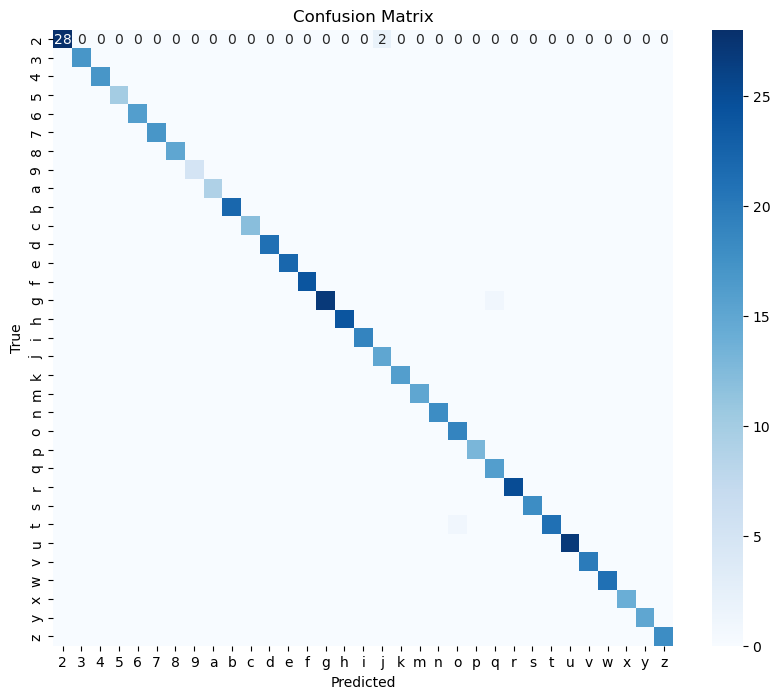

0.9933333333333333

In [22]:
# Evaluate the model
evaluate_model(model, val_loader)

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from sklearn.metrics import classification_report

def evaluate_model_and_save_to_file(model, data_loader, output_file, average='macro'):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get predictions
            all_preds.extend(preds.cpu().numpy())  # Store predicted labels
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    # Convert to numpy arrays for easier manipulation
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate precision, recall, and F1-score with average
    precision = precision_score(all_labels, all_preds, average=average)
    recall = recall_score(all_labels, all_preds, average=average)
    f1 = f1_score(all_labels, all_preds, average=average)

    # Calculate accuracy
    accuracy = np.mean(all_preds == all_labels)

    # Prepare output content
    output_content = f"""
    Precision ({average}): {precision:.4f}
    Recall ({average}): {recall:.4f}
    F1 Score ({average}): {f1:.4f}
    
    Accuracy: {accuracy * 100:.2f}%

    Classification Report:
    {classification_report(all_labels, all_preds, target_names=dataset.classes)}

    Confusion Matrix:
    {confusion_matrix(all_labels, all_preds)}

    """

    # Save the results to a text file
    with open(output_file, 'w') as file:
        file.write(output_content)
    
    print(f"Metrics saved to {output_file}")

    # Optional: Confusion matrix plot
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy


Metrics saved to metrics1.txt


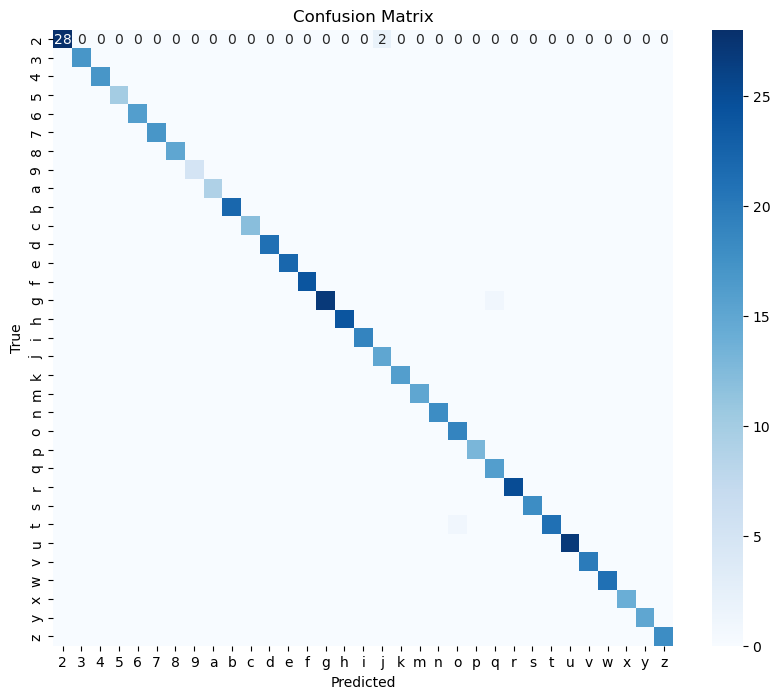

0.9933333333333333

In [36]:
# Example usage: Save the results to a file
output_file = "metrics1.txt"  # Path to save the results
evaluate_model_and_save_to_file(model, val_loader, output_file, average='macro')